<a href="https://colab.research.google.com/github/JairusTheAnalyst/JairusTheAnalyst/blob/main/OLAP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Question 1: Healthcare Data Analysis**

A county government wants to analyze healthcare data from a set of local clinics. The dataset includes clinic attendance, common ailments, and medication supply records over 6 months.



In [8]:
# module5_mini_project.py
import os
from pathlib import Path
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import hashlib
import datetime
import json

OUT = Path("./mini_project_outputs")
OUT.mkdir(exist_ok=True)


In [9]:
# -------------------------
# 1) Healthcare simulation
# -------------------------
np.random.seed(42)
n_clinics=10
n_days=180
clinic_ids = [f"C{str(i).zfill(2)}" for i in range(1,n_clinics+1)]
dates = pd.date_range(end=pd.Timestamp.today(), periods=n_days).tolist()
ailments = ["malaria","respiratory","diarrhea","flu","skin"]
rows=[]
for clinic in clinic_ids:
    base_pop = np.random.randint(50,200)
    for d in dates:
        day_idx = (d - dates[0]).days
        season_factor = 1 + 0.5 * np.sin(2 * np.pi * day_idx / 90)
        total_attendance = max(0, int(np.random.poisson(base_pop*season_factor)))
        counts = np.random.multinomial(total_attendance, np.random.dirichlet(np.ones(len(ailments))))
        med_supply = max(10, int(total_attendance*0.6 + np.random.normal(0,20)))
        rows.append({
            "clinic_id": clinic,
            "date": d.date(),
            "attendance": total_attendance,
            "med_supply": med_supply,
            "malaria": counts[0],
            "respiratory": counts[1],
            "diarrhea": counts[2],
            "flu": counts[3],
            "skin": counts[4]
        })
health_df = pd.DataFrame(rows)
health_df.to_csv(OUT/"healthcare_clinic_data.csv", index=False)


In [10]:
health_df.head()

,clinic_id,date,attendance,med_supply,malaria,respiratory,diarrhea,flu,skin
0,C01,2025-05-28,164,127,72,39,26,7,20
1,C01,2025-05-29,158,125,1,125,6,0,26
2,C01,2025-05-30,189,119,42,0,26,22,99
3,C01,2025-05-31,166,71,86,36,4,22,18
4,C01,2025-06-01,169,120,2,10,61,58,38


In [11]:
# PCA on healthcare features
features = ["attendance","med_supply","malaria","respiratory","diarrhea","flu","skin"]
X = health_df[features].values
Xs = StandardScaler().fit_transform(X)
pca = PCA(n_components=3)
X_pca = pca.fit_transform(Xs)
health_pca_df = pd.DataFrame(X_pca, columns=["PC1","PC2","PC3"])
health_pca_df[["clinic_id","date"]] = health_df[["clinic_id","date"]]
health_pca_df.to_csv(OUT/"healthcare_pca.csv", index=False)
health_pca_explained = pca.explained_variance_ratio_.round(4).tolist()

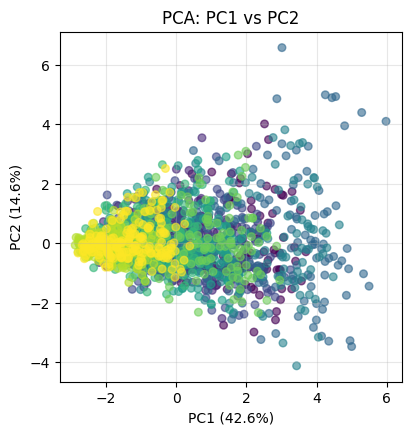

In [6]:
# Set up the plotting style
plt.style.use('default')
sns.set_palette("husl")

# Create the visualization
fig = plt.figure(figsize=(15, 10))

# 1. 2D Scatter plot of PC1 vs PC2
ax1 = plt.subplot(2, 3, 1)
scatter = ax1.scatter(health_pca_df['PC1'], health_pca_df['PC2'],
                     c=health_pca_df['clinic_id'].astype('category').cat.codes,
                     alpha=0.6, s=30)
ax1.set_xlabel(f'PC1 ({health_pca_explained[0]*100:.1f}%)')
ax1.set_ylabel(f'PC2 ({health_pca_explained[1]*100:.1f}%)')
ax1.set_title('PCA: PC1 vs PC2')
ax1.grid(True, alpha=0.3)

In [ ]:
# OLAP aggregation monthly
health_df["month"] = pd.to_datetime(health_df["date"]).dt.to_period("M")
agg_month = health_df.groupby("month").agg({
    "attendance":"sum","med_supply":"sum","malaria":"sum",
    "respiratory":"sum","diarrhea":"sum","flu":"sum","skin":"sum"
}).reset_index()
agg_month.to_csv(OUT/"health_monthly_agg.csv", index=False)

In [ ]:
# Anonymize clinic_id example
health_df["clinic_hash"] = health_df["clinic_id"].apply(lambda x: hashlib.sha256(x.encode()).hexdigest()[:10])
health_df.drop(columns=["clinic_id"], inplace=True)
health_df.to_csv(OUT/"healthcare_clinic_data_anonymized.csv", index=False)


**Question 2: Microloan Transaction Data Analysis**

You have a dataset containing monthly transaction logs from a Kenyan microloan provider. The dataset includes 500 features (variables) and millions of rows.

In [ ]:
# -------------------------
# 2) Microloan simulation (feature selection + PCA + model compare)
# -------------------------
n_rows = 50000
n_features = 100  # demo size (approach same for larger)
rng = np.random.RandomState(123)
X = rng.normal(0,1,size=(n_rows,n_features))
# create latent risk using 10 informative features
informative_idx = rng.choice(range(n_features), size=10, replace=False)
weights = rng.uniform(-1.5,1.5,size=10)
risk = rng.normal(0,1,size=n_rows)
for wi, idx in enumerate(informative_idx):
    risk += X[:,idx]*weights[wi]
prob = 1/(1+np.exp(-risk/2))
y = (rng.rand(n_rows) < prob).astype(int)

feature_names = [f"f{i}" for i in range(1,n_features+1)]
microloan_df = pd.DataFrame(X, columns=feature_names)
microloan_df["default"] = y
microloan_df.to_csv(OUT/"microloan_sample.csv", index=False)

In [ ]:
microloan_df.head()

,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,...,f92,f93,f94,f95,f96,f97,f98,f99,f100,default
0,-1.085631,0.997345,0.282978,-1.506295,-0.578600,1.651437,-2.426679,-0.428913,1.265936,-0.866740,...,-1.267352,0.181035,1.177862,-0.335011,1.031114,-1.084568,-1.363472,0.379401,-0.379176,1
1,0.642055,-1.977888,0.712265,2.598304,-0.024626,0.034142,0.179549,-1.861976,0.426147,-1.605410,...,-0.029968,0.199582,-0.126118,0.197019,-3.231055,-0.269293,-0.110851,-0.341262,-0.217946,0
2,0.703310,-0.598105,2.200702,0.688297,-0.006307,-0.206662,-0.086522,-0.915307,-0.095203,0.278684,...,0.668317,0.955832,-0.877614,-1.923716,0.695787,1.875801,0.415695,0.160544,0.819761,1
3,0.765055,-0.828989,-0.659151,0.611124,-0.144013,1.316606,-0.704342,0.750610,0.342638,-0.126438,...,1.161068,-0.098685,-0.214983,-1.773771,-0.407513,-0.291507,0.245379,-0.168426,0.244027,1
4,1.534090,-0.529914,-0.490972,-1.309165,-0.008660,0.976813,-1.751070,-0.665857,0.035941,0.850103,...,-0.232357,-0.824992,-0.256845,-1.050219,0.567880,0.512983,-0.026923,0.311582,-0.142051,0


In [ ]:
microloan_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Columns: 101 entries, f1 to default
dtypes: float64(100), int64(1)
memory usage: 38.5 MB


In [ ]:

# Feature selection using mutual information to pick top 10
selector = SelectKBest(mutual_info_classif, k=10)
selector.fit(microloan_df[feature_names].values, microloan_df["default"].values)
mask = selector.get_support()
selected = [f for f,m in zip(feature_names,mask) if m]
pd.Series(selected).to_csv(OUT/"microloan_selected_features.csv", index=False)

# PCA on selected features
Xs2 = StandardScaler().fit_transform(microloan_df[selected])
pca2 = PCA(n_components=3)
microloan_pca = pca2.fit_transform(Xs2)
pd.DataFrame(microloan_pca, columns=["PC1","PC2","PC3"]).assign(default=microloan_df["default"]).to_csv(OUT/"microloan_pca_selected.csv", index=False)


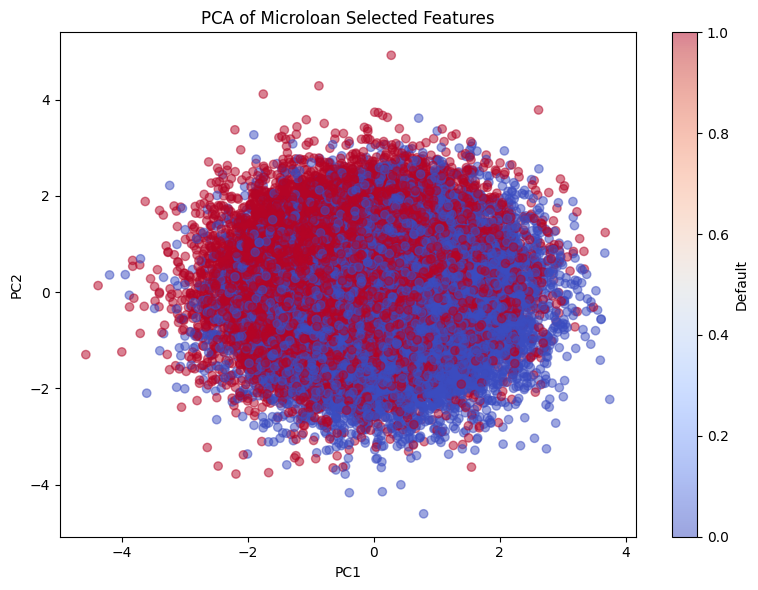

In [ ]:
import matplotlib.pyplot as plt

pca_df = pd.DataFrame(microloan_pca, columns=["PC1","PC2","PC3"])
pca_df["default"] = microloan_df["default"]

plt.figure(figsize=(8,6))
plt.scatter(pca_df["PC1"], pca_df["PC2"], c=pca_df["default"], cmap="coolwarm", alpha=0.5)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PCA of Microloan Selected Features")
plt.colorbar(label="Default")
plt.tight_layout()
plt.savefig(OUT/"microloan_pca_plot.png")
plt.show()


In [ ]:

# Model compare: RandomForest on full vs selected
X_train,X_test,y_train,y_test = train_test_split(microloan_df[feature_names], microloan_df["default"], test_size=0.3, random_state=42)
rf_full = RandomForestClassifier(n_estimators=50, max_depth=6, random_state=42, n_jobs=2)
rf_full.fit(X_train, y_train)
acc_full = accuracy_score(y_test, rf_full.predict(X_test))

X_train2,X_test2,y_train2,y_test2 = train_test_split(microloan_df[selected], microloan_df["default"], test_size=0.3, random_state=42)
rf_sel = RandomForestClassifier(n_estimators=50, max_depth=6, random_state=42, n_jobs=2)
rf_sel.fit(X_train2, y_train2)
acc_sel = accuracy_score(y_test2, rf_sel.predict(X_test2))

orig_size_mb = microloan_df[feature_names].memory_usage(deep=True).sum()/1024**2
sel_size_mb = microloan_df[selected].memory_usage(deep=True).sum()/1024**2

# Save metrics
metrics = {
    "microloan_accuracy_full": float(acc_full),
    "microloan_accuracy_selected": float(acc_sel),
    "orig_size_mb": float(orig_size_mb),
    "selected_size_mb": float(sel_size_mb),
    "selected_features": selected,
    "pca2_explained_variance": pca2.explained_variance_ratio_.round(4).tolist(),
    "health_pca_explained": health_pca_explained
}
with open(OUT/"analysis_metrics.json","w") as f:
    json.dump(metrics, f, indent=2)


In [ ]:
# -------------------------
# 3) OLAP simulation (sales: slice, drill-down, roll-up)
# -------------------------
stores=["Store_A","Store_B","Store_C"]
cats=["Groceries","Electronics","Clothing"]
dates_sales = pd.date_range(end=pd.Timestamp.today(), periods=90).tolist()
sales=[]
import numpy as np
for s in stores:
    for d in dates_sales:
        for cat in cats:
            qty = int(abs(int(np.random.poisson(20))))
            price = {"Groceries":5,"Electronics":200,"Clothing":35}[cat]
            sales.append({"store":s,"date":d.date(),"category":cat,"quantity":qty,"total":qty*price})
sales_df = pd.DataFrame(sales)
sales_df.to_csv(OUT/"sales_data.csv", index=False)

In [ ]:
sales_df.head()

,store,date,category,quantity,total
0,Store_A,2025-08-23,Groceries,15,75
1,Store_A,2025-08-23,Electronics,19,3800
2,Store_A,2025-08-23,Clothing,18,630
3,Store_A,2025-08-24,Groceries,12,60
4,Store_A,2025-08-24,Electronics,21,4200


In [ ]:

# slice by Electronics
sales_df[sales_df["category"]=="Electronics"].to_csv(OUT/"sales_slice_electronics.csv", index=False)
# drill-down example for Store_A monthly -> daily
sales_df["month"] = pd.to_datetime(sales_df["date"]).dt.to_period("M")
storeA_monthly = sales_df[sales_df["store"]=="Store_A"].groupby("month").agg({"total":"sum"}).reset_index()
storeA_daily = sales_df[sales_df["store"]=="Store_A"].groupby("date").agg({"total":"sum"}).reset_index()
storeA_monthly.to_csv(OUT/"storeA_monthly.csv", index=False)
storeA_daily.to_csv(OUT/"storeA_daily.csv", index=False)
# roll-up quarter by quarter
sales_df["quarter"] = pd.to_datetime(sales_df["date"]).dt.to_period("Q")
quarterly = sales_df.groupby("quarter").agg({"total":"sum"}).reset_index()
quarterly.to_csv(OUT/"quarterly_sales.csv", index=False)

**Question 3: Data Warehouse Analysis**

Using the data warehouse setup from this module, perform the following analysis:

The data warehouse contains sales data with fields such as store, date, category, quantity, and total. Using OLAP operations, we can extract strategic insights by slicing, drilling down, and rolling up the data.

1. **Slice the Data by a Specific Product Category**

A slice filters the data warehouse along one dimension while keeping others intact.
In this case, we extract only Electronics-related sales.

In [ ]:
# Slice: filter by Electronics category
electronics_slice = sales_df[sales_df["category"] == "Electronics"]
electronics_slice.to_csv(OUT/"sales_slice_electronics.csv", index=False)


This slice helps management understand patterns such as pricing effectiveness, demand cycles, or stock movement specific to Electronics. It isolates one category without altering store or date dimensions.



2. **Drill-Down from Monthly Summary to Daily Data for One Store Location**

Drill-down moves from a higher level of aggregation to a more detailed level.
Starting with monthly totals, we drill down for Store_A to its daily sales.

In [ ]:
# Convert date to month
sales_df["month"] = pd.to_datetime(sales_df["date"]).dt.to_period("M")

# Monthly summary for Store_A
storeA_monthly = sales_df[sales_df["store"] == "Store_A"] \
                    .groupby("month")["total"].sum().reset_index()
storeA_monthly

# Daily summary (drill-down)
storeA_daily = sales_df[sales_df["store"] == "Store_A"] \
                  .groupby("date")["total"].sum().reset_index()
storeA_daily

storeA_monthly.to_csv(OUT/"storeA_monthly.csv", index=False)
storeA_daily.to_csv(OUT/"storeA_daily.csv", index=False)


In [ ]:
storeA_monthly

,month,total
0,2025-08,42220
1,2025-09,144775
2,2025-10,148475
3,2025-11,100260


Managers can compare monthly trends (e.g., seasonal demand) and then drill down to daily activity to detect operational issues such as specific-day dips, holiday spikes, or stock-out events.

3. **Roll-Up to View Quarter-by-Quarter Sales**

Roll-up moves from detailed data to a higher aggregation level.
Here, we roll up the daily data into quarterly sales totals.

In [ ]:
# Convert date to quarter
sales_df["quarter"] = pd.to_datetime(sales_df["date"]).dt.to_period("Q")

# Roll-up: quarterly aggregation
quarterly_sales = sales_df.groupby("quarter")["total"].sum().reset_index()
quarterly_sales.to_csv(OUT/"quarterly_sales.csv", index=False)


In [ ]:
quarterly_sales

,quarter,total
0,2025Q3,557160
1,2025Q4,731235
